<a href="https://colab.research.google.com/github/jade0520/Conformer_code_review/blob/main/Conformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper Link
[Conformer pdf] https://arxiv.org/pdf/2005.08100.pdf?ref=https://githubhelp.com  
[Trasformer pdf] https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf



# Activation

In [ ]:
# Activation
import torch.nn as nn
from torch import Tensor


class Swish(nn.Module):
    """
    Swish is a smooth, non-monotonic function that consistently matches or outperforms ReLU on deep networks applied
    to a variety of challenging domains such as Image classification and Machine translation.
    """
    def __init__(self):
        super(Swish, self).__init__()
    
    def forward(self, inputs: Tensor) -> Tensor:
        return inputs * inputs.sigmoid()


class GLU(nn.Module):
    """
    The gating mechanism is called Gated Linear Units (GLU), which was first introduced for natural language processing
    in the paper “Language Modeling with Gated Convolutional Networks”
    """
    def __init__(self, dim: int) -> None:
        super(GLU, self).__init__()
        self.dim = dim

    def forward(self, inputs: Tensor) -> Tensor:
        outputs, gate = inputs.chunk(2, dim=self.dim) # chunk : https://pytorch.org/docs/stable/generated/torch.chunk.html
        return outputs * gate.sigmoid()


# embedding

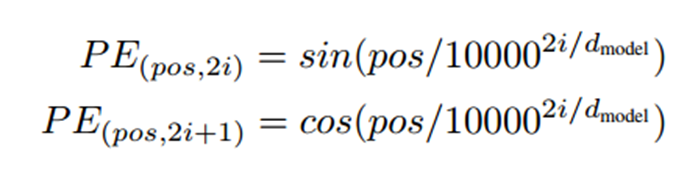

In [ ]:
import math
import torch
import torch.nn as nn
from torch import Tensor

class PositionalEncoding(nn.Module):
    """
    Positional Encoding proposed in "Attention Is All You Need".
    Since transformer contains no recurrence and no convolution, in order for the model to make
    use of the order of the sequence, we must add some positional information.

    "Attention Is All You Need" use sine and cosine functions of different frequencies:
        PE_(pos, 2i)    =  sin(pos / power(10000, 2i / d_model))
        PE_(pos, 2i+1)  =  cos(pos / power(10000, 2i / d_model))
    """
    def __init__(self, d_model: int = 512, max_len: int = 10000) -> None:
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model, requires_grad=False)               # 임베딩해야할 거 크기 구현 - zero padding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)   # 0부터 max_len끼지를 요소로 하는 텐서 구현 후 1차원 추가 (< 왜?, 결과는 같음)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)                         # 0::2 -> 0부터 시작해서 두 칸씩 뛰어라
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, length: int) -> Tensor:
        return self.pe[:, :length]

## Embedding TEST

In [ ]:
enc = PositionalEncoding()


In [ ]:
position = torch.arange(0, 10000, dtype=torch.float)
position[1::2]
position[0::2]

tensor([0.0000e+00, 2.0000e+00, 4.0000e+00,  ..., 9.9940e+03, 9.9960e+03,
        9.9980e+03])

In [ ]:
position = torch.arange(0, 10000, dtype=torch.float).unsqueeze(1) 
position

tensor([[0.0000e+00],
        [1.0000e+00],
        [2.0000e+00],
        ...,
        [9.9970e+03],
        [9.9980e+03],
        [9.9990e+03]])

### Refs
[torch.arange](https://pytorch.org/docs/stable/generated/torch.arange.html)
[]


#Modules

In [ ]:
# Copyright (c) 2021, Soohwan Kim. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
import torch.nn as nn
import torch.nn.init as init
from torch import Tensor


class ResidualConnectionModule(nn.Module):
    """
    Residual Connection Module.
    outputs = (module(inputs) x module_factor + inputs x input_factor)
    """
    def __init__(self, module: nn.Module, module_factor: float = 1.0, input_factor: float = 1.0):
        super(ResidualConnectionModule, self).__init__()
        self.module = module
        self.module_factor = module_factor
        self.input_factor = input_factor

    def forward(self, inputs: Tensor) -> Tensor:
        return (self.module(inputs) * self.module_factor) + (inputs * self.input_factor)


class Linear(nn.Module): #!!! 논문에는 안나와 있음
    """
    Wrapper class of torch.nn.Linear
    Weight initialize by xavier initialization and bias initialize to zeros. -> 이거 하려고 새로 생성한 linear class . nn.Linear는 초기화 방법이 정해져있음.
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True) -> None:
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)  # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        init.xavier_uniform_(self.linear.weight) # 노드가 n개일 때, 표준편차가 (n)^-1/2인 정규분포로 초기화
        if bias:
            init.zeros_(self.linear.bias)

    def forward(self, x: Tensor) -> Tensor:
        return self.linear(x)


class View(nn.Module):
  # 모듈로서 사용하기 위함. 초기화 하고 forward때 사용.
  # contiguous : 메모리 상에서 연속이도록.
    """ Wrapper class of torch.view() for Sequential module. """
    def __init__(self, shape: tuple, contiguous: bool = False):
        super(View, self).__init__()
        self.shape = shape
        self.contiguous = contiguous

    def forward(self, x: Tensor) -> Tensor:
        if self.contiguous:
            x = x.contiguous()

        return x.view(*self.shape)


class Transpose(nn.Module):
  # 모듈로서 사용하기 위함. 초기화 하고 forward때 사용.
    """ Wrapper class of torch.transpose() for Sequential module. """
    def __init__(self, shape: tuple):
        super(Transpose, self).__init__()
        self.shape = shape

    def forward(self, x: Tensor) -> Tensor:
        return x.transpose(*self.shape)


# Feed_forward

In [ ]:
import torch
import torch.nn as nn
from torch import Tensor

"""
from .activation import Swish
from .modules import Linear
"""

class FeedForwardModule(nn.Module):
    # 블록 그대로
    """
    Conformer Feed Forward Module follow pre-norm residual units and apply layer normalization within the residual unit
    and on the input before the first linear layer. This module also apply Swish activation and dropout, which helps
    regularizing the network.

    Args:
        encoder_dim (int): Dimension of conformer encoder
        expansion_factor (int): Expansion factor of feed forward module.
        dropout_p (float): Ratio of dropout

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor contains input sequences

    Outputs: outputs
        - **outputs** (batch, time, dim): Tensor produces by feed forward module.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            expansion_factor: int = 4,
            dropout_p: float = 0.1,
    ) -> None:
        super(FeedForwardModule, self).__init__()
        self.sequential = nn.Sequential(
            nn.LayerNorm(encoder_dim),
            Linear(encoder_dim, encoder_dim * expansion_factor, bias=True),
            Swish(),
            nn.Dropout(p=dropout_p),
            Linear(encoder_dim * expansion_factor, encoder_dim, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)


#Convolution ?

In [ ]:

import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple
"""
from .activation import Swish, GLU
from .modules import Transpose
"""

class DepthwiseConv1d(nn.Module):
    """
    When groups == in_channels and out_channels == K * in_channels, where K is a positive integer,
    this operation is termed in literature as depthwise convolution.

    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True

    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector

    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by depthwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = False,
    ) -> None:
        super(DepthwiseConv1d, self).__init__()
        assert out_channels % in_channels == 0, "out_channels should be constant multiple of in_channels"
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)


class PointwiseConv1d(nn.Module):
    """
    When kernel size == 1 conv1d, this operation is termed in literature as pointwise convolution.
    This operation often used to match dimensions.

    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True

    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector

    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by pointwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = True,
    ) -> None:
        super(PointwiseConv1d, self).__init__()
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)


class ConformerConvModule(nn.Module):
    """
    Conformer convolution module starts with a pointwise convolution and a gated linear unit (GLU).
    This is followed by a single 1-D depthwise convolution layer. Batchnorm is  deployed just after the convolution
    to aid training deep models.

    Args:
        in_channels (int): Number of channels in the input
        kernel_size (int or tuple, optional): Size of the convolving kernel Default: 31
        dropout_p (float, optional): probability of dropout

    Inputs: inputs
        inputs (batch, time, dim): Tensor contains input sequences

    Outputs: outputs
        outputs (batch, time, dim): Tensor produces by conformer convolution module.
    """
    def __init__(
            self,
            in_channels: int,
            kernel_size: int = 31,
            expansion_factor: int = 2,
            dropout_p: float = 0.1,
    ) -> None:
        super(ConformerConvModule, self).__init__()
        assert (kernel_size - 1) % 2 == 0, "kernel_size should be a odd number for 'SAME' padding"
        assert expansion_factor == 2, "Currently, Only Supports expansion_factor 2"

        self.sequential = nn.Sequential(
            nn.LayerNorm(in_channels),
            Transpose(shape=(1, 2)),
            PointwiseConv1d(in_channels, in_channels * expansion_factor, stride=1, padding=0, bias=True),
            GLU(dim=1),
            DepthwiseConv1d(in_channels, in_channels, kernel_size, stride=1, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(in_channels),
            Swish(),
            PointwiseConv1d(in_channels, in_channels, stride=1, padding=0, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs).transpose(1, 2)


class Conv2dSubampling(nn.Module):
    """
    Convolutional 2D subsampling (to 1/4 length)

    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs

    Returns: outputs, output_lengths
        - **outputs** (batch, time, dim): Tensor produced by the convolution
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(Conv2dSubampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
        )

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, sumsampled_dim = outputs.size()

        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * sumsampled_dim)

        output_lengths = input_lengths >> 2 # 비트 쉬프트 연산, 2의 2승 만큼 나눠짐
        output_lengths -= 1

        return outputs, output_lengths


# Attention*


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Optional

"""
from .embedding import PositionalEncoding
from .modules import Linear
"""

class RelativeMultiHeadAttention(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    This concept was proposed in the "Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context"

    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout

    Inputs: query, key, value, pos_embedding, mask
        - **query** (batch, time, dim): Tensor containing query vector
        - **key** (batch, time, dim): Tensor containing key vector
        - **value** (batch, time, dim): Tensor containing value vector
        - **pos_embedding** (batch, time, dim): Positional embedding tensor
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked

    Returns:
        - **outputs**: Tensor produces by relative multi head attention module.
    """
    def __init__(
            self,
            d_model: int = 512,
            num_heads: int = 16,
            dropout_p: float = 0.1,
    ):
        super(RelativeMultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model % num_heads should be zero."
        self.d_model = d_model
        self.d_head = int(d_model / num_heads)
        self.num_heads = num_heads
        self.sqrt_dim = math.sqrt(d_model)

        self.query_proj = Linear(d_model, d_model)
        self.key_proj = Linear(d_model, d_model)
        self.value_proj = Linear(d_model, d_model)
        self.pos_proj = Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(p=dropout_p)
        self.u_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        self.v_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        torch.nn.init.xavier_uniform_(self.u_bias)
        torch.nn.init.xavier_uniform_(self.v_bias)

        self.out_proj = Linear(d_model, d_model)

    def forward(
            self,
            query: Tensor,
            key: Tensor,
            value: Tensor,
            pos_embedding: Tensor,
            mask: Optional[Tensor] = None,
    ) -> Tensor:
        batch_size = value.size(0)

        # n heads 한번에 계산
        query = self.query_proj(query).view(batch_size, -1, self.num_heads, self.d_head)
        key = self.key_proj(key).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value_proj(value).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        ## embedding에서 들어오는것 linear를 한번 거침: Transformer-XL
        pos_embedding = self.pos_proj(pos_embedding).view(batch_size, -1, self.num_heads, self.d_head)

        ## 상대위치 기반 셀프 어텐션 식: Transformer-XL
        ### a,c 항
        content_score = torch.matmul((query + self.u_bias).transpose(1, 2), key.transpose(2, 3))
        ### b,d 항
        pos_score = torch.matmul((query + self.v_bias).transpose(1, 2), pos_embedding.permute(0, 2, 3, 1)) 
        pos_score = self._relative_shift(pos_score) # 왼쪽으로 미뤄주는 것

        ## scale : Transformer-XL
        score = (content_score + pos_score) / self.sqrt_dim # 텐서 더하기는 요소별 더하기 : 형태는 유지

        ## Masking 옵션
        if mask is not None:
            mask = mask.unsqueeze(1)
            score.masked_fill_(mask, -1e9)

        ## Softmax
        attn = F.softmax(score, -1)
        ## Dropout ------------------------------->? 
        attn = self.dropout(attn)
        ## value랑 matmul
        context = torch.matmul(attn, value).transpose(1, 2)
        context = context.contiguous().view(batch_size, -1, self.d_model)

        # concat 후 linear
        return self.out_proj(context)

    def _relative_shift(self, pos_score: Tensor) -> Tensor:
      
        batch_size, num_heads, seq_length1, seq_length2 = pos_score.size()
        print(" batch_size {} num_heads {} seq_length1 {} seq_length2 {}".format( batch_size, num_heads, seq_length1, seq_length2))
        zeros = pos_score.new_zeros(batch_size, num_heads, seq_length1, 1) # pos_score의 devidce, type따라가는 zero
        padded_pos_score = torch.cat([zeros, pos_score], dim=-1) 

        padded_pos_score = padded_pos_score.view(batch_size, num_heads, seq_length2 + 1, seq_length1)
        pos_score = padded_pos_score[:, :, 1:].view_as(pos_score)


        return pos_score


class MultiHeadedSelfAttentionModule(nn.Module):
    """
    Conformer employ multi-headed self-attention (MHSA) while integrating an important technique from Transformer-XL,
    the relative sinusoidal positional encoding scheme. The relative positional encoding allows the self-attention
    module to generalize better on different input length and the resulting encoder is more robust to the variance of
    the utterance length. Conformer use prenorm residual units with dropout which helps training
    and regularizing deeper models.

    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout

    Inputs: inputs, mask
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked

    Returns:
        - **outputs** (batch, time, dim): Tensor produces by relative multi headed self attention module.
    """
    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.1):
        super(MultiHeadedSelfAttentionModule, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.attention = RelativeMultiHeadAttention(d_model, num_heads, dropout_p)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, inputs: Tensor, mask: Optional[Tensor] = None):
        batch_size, seq_length, _ = inputs.size()
        pos_embedding = self.positional_encoding(seq_length)
        pos_embedding = pos_embedding.repeat(batch_size, 1, 1)

        inputs = self.layer_norm(inputs)
        outputs = self.attention(inputs, inputs, inputs, pos_embedding=pos_embedding, mask=mask)

        return self.dropout(outputs)


#Encoder
구조를 이루는 class

In [ ]:
# Copyright (c) 2021, Soohwan Kim. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple
"""
from .feed_forward import FeedForwardModule
from .attention import MultiHeadedSelfAttentionModule
from .convolution import (
    ConformerConvModule,
    Conv2dSubampling,
)
from .modules import (
    ResidualConnectionModule,
    Linear,
)
"""

class ConformerBlock(nn.Module):
    """
    Conformer block contains two Feed Forward modules sandwiching the Multi-Headed Self-Attention module
    and the Convolution module. This sandwich structure is inspired by Macaron-Net, which proposes replacing
    the original feed-forward layer in the Transformer block into two half-step feed-forward layers,
    one before the attention layer and one after.

    Args:
        encoder_dim (int, optional): Dimension of conformer encoder
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector

    Returns: outputs
        - **outputs** (batch, time, dim): Tensor produces by conformer block.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerBlock, self).__init__()
        if half_step_residual:
            self.feed_forward_residual_factor = 0.5 # Macaron인 대신에 0.5
        else:
            self.feed_forward_residual_factor = 1

        self.sequential = nn.Sequential(
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            ResidualConnectionModule(
                module=MultiHeadedSelfAttentionModule(
                    d_model=encoder_dim,
                    num_heads=num_attention_heads,
                    dropout_p=attention_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=ConformerConvModule(
                    in_channels=encoder_dim,
                    kernel_size=conv_kernel_size,
                    expansion_factor=conv_expansion_factor,
                    dropout_p=conv_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            nn.LayerNorm(encoder_dim),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)


class ConformerEncoder(nn.Module):
    """
    Conformer encoder first processes the input with a convolution subsampling layer and then
    with a number of conformer blocks.

    Args:
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not

    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths

    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer encoder.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            input_dim: int = 80,
            encoder_dim: int = 512,
            num_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerEncoder, self).__init__()
        self.conv_subsample = Conv2dSubampling(in_channels=1, out_channels=encoder_dim)
        self.input_projection = nn.Sequential(
            Linear(encoder_dim * (((input_dim - 1) // 2 - 1) // 2), encoder_dim),
            nn.Dropout(p=input_dropout_p),
        )
        self.layers = nn.ModuleList([ConformerBlock(
            encoder_dim=encoder_dim,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        ) for _ in range(num_layers)])

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return sum([p.numel for p in self.parameters()])

    def update_dropout(self, dropout_p: float) -> None:
        """ Update dropout probability of encoder """
        for name, child in self.named_children():
            if isinstance(child, nn.Dropout):
                child.p = dropout_p

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` for  encoder training.

        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``

        Returns:
            (Tensor, Tensor)

            * outputs (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
            * output_lengths (torch.LongTensor): The length of output tensor. ``(batch)``
        """
        outputs, output_lengths = self.conv_subsample(inputs, input_lengths)
        outputs = self.input_projection(outputs)

        for layer in self.layers:
            outputs = layer(outputs)

        return outputs, output_lengths


#model 
전체 연결

In [ ]:
# Copyright (c) 2021, Soohwan Kim. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple

"""
from .encoder import ConformerEncoder
from .modules import Linear
"""

class Conformer(nn.Module):
    """
    Conformer: Convolution-augmented Transformer for Speech Recognition
    The paper used a one-lstm Transducer decoder, currently still only implemented
    the conformer encoder shown in the paper.

    Args:
        num_classes (int): Number of classification classes
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_encoder_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths

    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            num_classes: int,
            input_dim: int = 80,
            encoder_dim: int = 512,
            num_encoder_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ) -> None:
        super(Conformer, self).__init__()
        self.encoder = ConformerEncoder(
            input_dim=input_dim,
            encoder_dim=encoder_dim,
            num_layers=num_encoder_layers,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            input_dropout_p=input_dropout_p,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        )
        self.fc = Linear(encoder_dim, num_classes, bias=False)

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return self.encoder.count_parameters()

    def update_dropout(self, dropout_p) -> None:
        """ Update dropout probability of model """
        self.encoder.update_dropout(dropout_p)

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` and `targets` pair for training.

        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``

        Returns:
            * predictions (torch.FloatTensor): Result of model predictions.
        """
        encoder_outputs, encoder_output_lengths = self.encoder(inputs, input_lengths)
        outputs = self.fc(encoder_outputs)
        outputs = nn.functional.log_softmax(outputs, dim=-1)
        return outputs, encoder_output_lengths


# TEST

In [ ]:
"""
    Conformer Inputs
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths
"""
            #encoder_dim: int = 512,
            #num_encoder_layers: int = 17,
            #num_attention_heads: int = 8,
            #feed_forward_expansion_factor: int = 4,
            #nv_expansion_factor: int = 2,
            #input_dropout_p: float = 0.1,
            #feed_forward_dropout_p: float = 0.1,
            #attention_dropout_p: float = 0.1,
            #conv_dropout_p: float = 0.1,
            #conv_kernel_size: int = 31,
            #half_step_residual: bool = True,

Batch_size = 5
input_dim = 80
input_length = 10

model = Conformer(num_classes = 3, input_dim = input_dim)
dum_data = torch.randn(Batch_size, input_length, input_dim) # (2,3) 크기를 같는 랜덤 텐서 생성 :  https://pytorch.org/docs/stable/generated/torch.rand.html
input_lengths = torch.tensor([input_length]*Batch_size)  #[10, 10, 10, 10, 10]

outputs, output_lengths = model(dum_data, input_lengths)
outputs.size() #torch.Size([5, 1, 3])
 

before shift tensor([[[[  2.6747]],

         [[  5.1723]],

         [[ -0.7950]],

         [[ -2.6228]],

         [[  1.2504]],

         [[ -0.1003]],

         [[ -0.0339]],

         [[ -8.9552]]],


        [[[  8.6664]],

         [[ 13.8540]],

         [[  8.3596]],

         [[ -8.8623]],

         [[  2.9194]],

         [[ -2.4039]],

         [[  2.9085]],

         [[ -5.9977]]],


        [[[  7.7767]],

         [[ 11.7281]],

         [[  3.1200]],

         [[ -5.8037]],

         [[  7.9312]],

         [[ -0.0364]],

         [[  3.0293]],

         [[  0.9338]]],


        [[[  5.7425]],

         [[  6.5794]],

         [[ -1.5250]],

         [[ -3.1990]],

         [[  2.7679]],

         [[ -5.1100]],

         [[  2.6525]],

         [[  2.0846]]],


        [[[  5.6113]],

         [[  9.6051]],

         [[ -1.5421]],

         [[-10.4818]],

         [[  1.2267]],

         [[ -4.5101]],

         [[  0.4637]],

         [[  0.7807]]]], grad_fn=<UnsafeVie

torch.Size([5, 1, 3])